# Uebung 4

## Aufgabe 1

Erstellen Sie ein Polygon in einer vernünftigen Grösse ähnlich wie die Rigi-Szene. Das Polygon kann z.B. auf https://map.geo.admin.ch gezeichnet werden und die Koordinaten in ein WKT übernommen werden. (Unter "Zeichnen und Messen auf der Karte")

- a) Laden Sie alle Daten herunter und rrstellen Sie einen vrt (virtuellen Datensatz) mit all den Höhendaten
Die Daten müssen dabei in das unten erstelle Verzeichnis `basedir` kopiert werden, dort hat es einige Terabytes Speicherplatz zur Verfügung.




In [1]:
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import shapely.wkt
import os
import geopandas_stac as stac
import geoutils

In [2]:
# Die Daten dieses Notebooks werden im Ordner daten/elv gespeichert
# Vorsicht bei Änderungen: basedir muss mit "/" enden!
basedir = "daten/u4/"

if not os.path.exists(basedir):
    os.mkdir(basedir)

In [3]:
# Eine Hilfsfunktion, welche zu einem POLYGON die entsprechenden Rasterbilder zurückgibt.
# Format: TIFF, GSD 0.5m
# Das Resultat ist eine Liste mit 0 oder n URL-Zeichenetten.

def getSwissalti3d_50cm_poly(wkt):
    df = stac.getAssets("ch.swisstopo.swissalti3d")

    df_geotiff = df.query('type == "image/tiff; application=geotiff; profile=cloud-optimized"')
    df_geotiff = df_geotiff.query("gsd == 0.5")

    polygon = shapely.wkt.loads(wkt)
    dfpoly = gpd.GeoDataFrame(geometry=gpd.GeoSeries(polygon, crs="epsg:4326"))
    df_result = gpd.sjoin(df_geotiff, dfpoly, op='intersects')
    
    return stac.getUrlList(df_result)

In [ ]:
# https://s.geo.admin.ch/9283bf7d28
obl = 47.51015, 9.29433
#obr = 47.46935, 9.62152
obr = 47.47111, 9.47563
#unr = 47.35064, 9.61865
unr = 47.35329, 9.47311
unl = 47.35557, 9.33948

In [7]:
s = 'POLYGON ((9.29433 47.51015, 9.47563 47.47111, 9.47311 47.35329, 9.33948 47.35557, 9.29433 47.51015))'
urls = getSwissalti3d_50cm_poly(s)

In [8]:
len(urls)

208

In [10]:
for url in urls:
    filename = basedir + os.path.basename(url)
    geoutils.download(url, filename, False)  # mit dem False wird verhindert, dass neu heruntergeladen wird

100% done 	[****************************************************************************************************]
100% done 	[****************************************************************************************************]
100% done 	[****************************************************************************************************]
100% done 	[****************************************************************************************************]
100% done 	[****************************************************************************************************]
100% done 	[****************************************************************************************************]
100% done 	[****************************************************************************************************]
100% done 	[****************************************************************************************************]
100% done 	[****************************************************************************

In [12]:
# **FIX**
# Overviews / Pyramiden entfernen:

for url in urls:
    filename = basedir + os.path.basename(url)
    !gdaladdo -clean $filename

In [13]:
vrt = basedir + "sg.vrt"
tifs = basedir + "*.tif"

In [15]:
# vrt aus tifs erstellen
!gdalbuildvrt $vrt $tifs

0...10...20...30...40...50...60...70...80...90...100 - done.


In [16]:
# Bildpyramiden/Overviews über den zusammengesetzen Datensatz rechnen
!gdaladdo -r average $vrt 2 4 8 16 32

0...10...20...30...40...50...60...70...80...90...100 - done.


- b) Ermitteln Sie die Grösse (Breite, Höhe) des virtuellen Datensatz. Wie viel Speicher würde benötigt, wennn der gesamte Datensatz geladen würde ? (Anmerkung: ein Höhenwert ist float32 und benötigt 4 Bytes)



In [17]:
!gdalinfo $vrt

Driver: VRT/Virtual Raster
Files: daten/u4/sg.vrt
       daten/u4/sg.vrt.ovr
       daten/u4/swissalti3d_2019_2740-1258_0.5_2056_5728.tif
       daten/u4/swissalti3d_2019_2741-1256_0.5_2056_5728.tif
       daten/u4/swissalti3d_2019_2741-1258_0.5_2056_5728.tif
       daten/u4/swissalti3d_2019_2741-1260_0.5_2056_5728.tif
       daten/u4/swissalti3d_2019_2742-1249_0.5_2056_5728.tif
       daten/u4/swissalti3d_2019_2742-1250_0.5_2056_5728.tif
       daten/u4/swissalti3d_2019_2742-1262_0.5_2056_5728.tif
       daten/u4/swissalti3d_2019_2743-1246_0.5_2056_5728.tif
       daten/u4/swissalti3d_2019_2743-1249_0.5_2056_5728.tif
       daten/u4/swissalti3d_2019_2743-1251_0.5_2056_5728.tif
       daten/u4/swissalti3d_2019_2743-1254_0.5_2056_5728.tif
       daten/u4/swissalti3d_2019_2743-1258_0.5_2056_5728.tif
       daten/u4/swissalti3d_2019_2743-1260_0.5_2056_5728.tif
       daten/u4/swissalti3d_2019_2744-1258_0.5_2056_5728.tif
       daten/u4/swissalti3d_2019_2745-1246_0.5_2056_5728.tif
       d

In [23]:
print('Der Datensatz würde '+str(30000*36000*4/1024/1024/1024)+' GB Speicherplatz brauchen.')

Der Datensatz würde 4.023313522338867 GB Speicherplatz brauchen.


- c) Erstellen Sie unter Verwendung von `gdal_translate` eine reduzierte Grösse dieses Datensatzes (um 1000-2000 Pixel Breite/Höhe)


In [25]:
!gdal_translate -of GTiff $vrt daten/u4/sg.tif -outsize 1000 0 -a_srs EPSG:2056

Input file size is 30000, 36000
0...10...20...30...40...50...60...70...80...90...100 - done.


- d) Erstellen SIe eine Geländeschummerung, mit der -az Option (Azimuth) kann der Winkel des Lichteinfalls verändert werden

In [26]:
!gdaldem hillshade daten/u4/sg.tif daten/u4/hillshade2.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


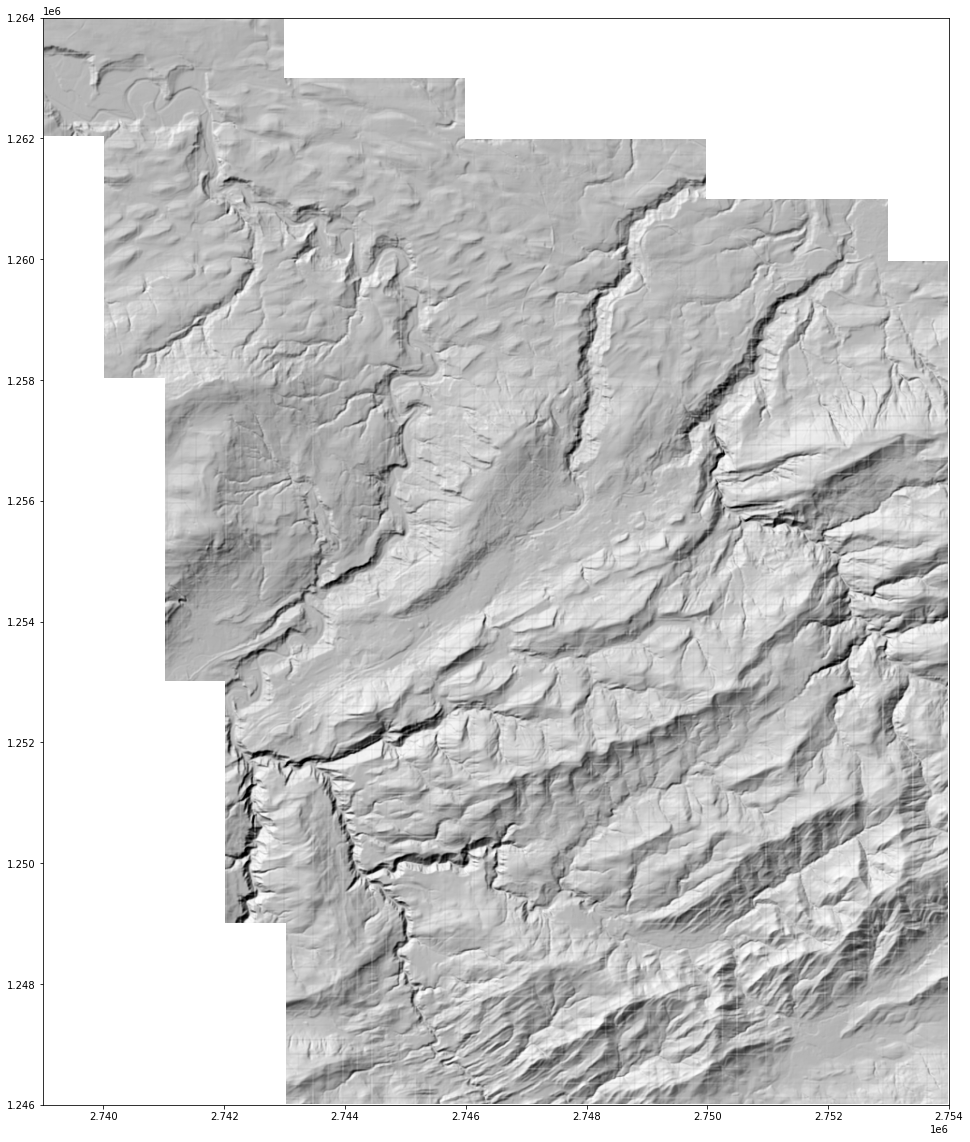

In [27]:
dataset = rasterio.open("daten/u4/hillshade2.tif")
fig, ax = plt.subplots(figsize=(20, 20))
rasterio.plot.show(dataset, cmap='gray', ax=ax)
dataset.close()




- e) Erstellen Sie mit gdaldem auch eine slope map `gdaldem slope`




In [28]:
!gdaldem slope daten/u4/sg.tif daten/u4/slope.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


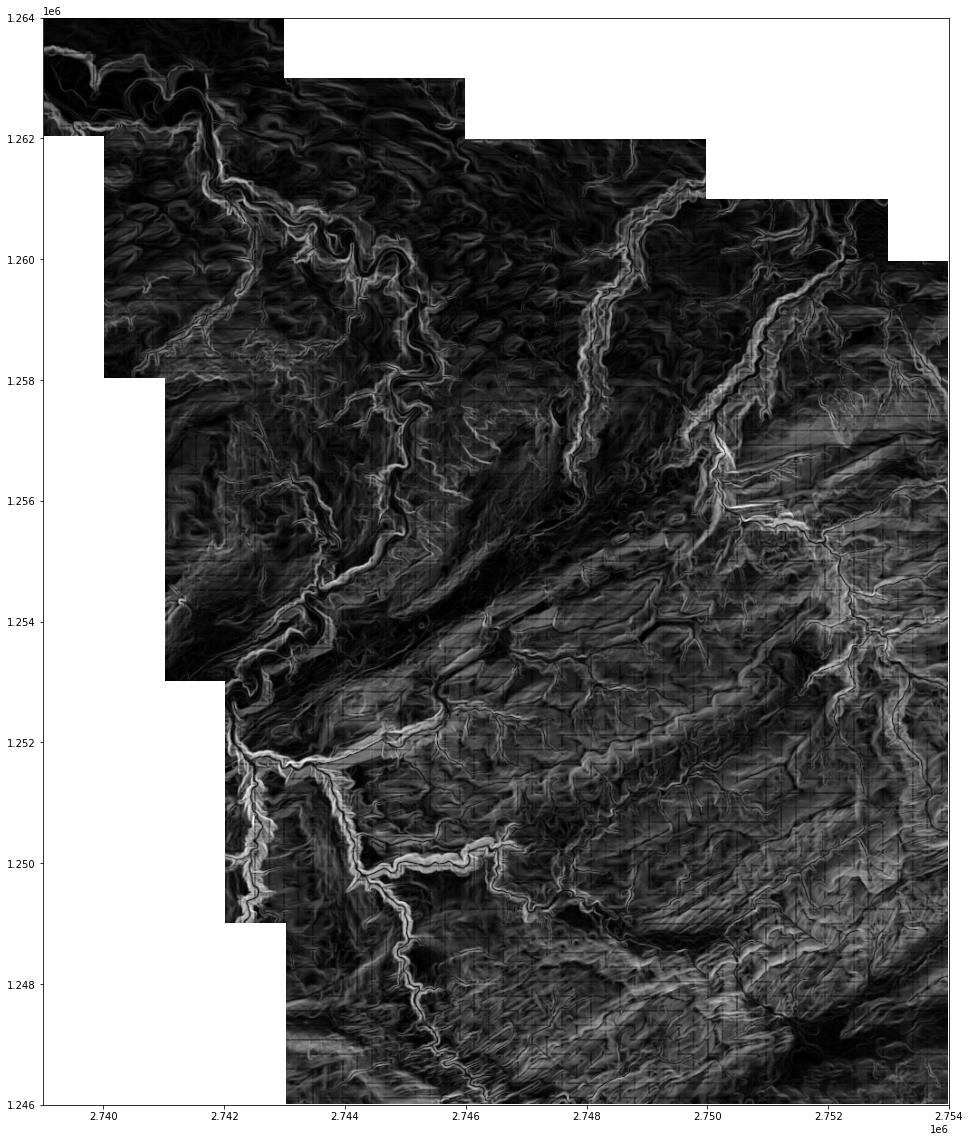

In [29]:
dataset = rasterio.open("daten/u4/slope.tif")
fig, ax = plt.subplots(figsize=(20, 20))
rasterio.plot.show(dataset, cmap='gray', ax=ax)
dataset.close()

Und wenn noch Zeit übrig: Ein 3D Modell

In [30]:
# Wir nehmen das skalierte File, um es überschaubar zu machen, aber es ist natürlich
# kein Problem hier auch die Originalauflösung zu nehmen.
dataset = rasterio.open("daten/u4/sg.tif")

elv = dataset.read(1)

# Die Mitte in LV95. Wird als offset genommen, dann ist das Modell zentriert
center = dataset.transform * (dataset.width/2,dataset.height/2)

file = open("daten/u4/sg.obj", "w")
file.write("# Terrain, created with Python\n#\n#\n")
file.write(f"# Offset: {center}\n\n")
 
## Vertices v
for y in range(dataset.height):
    for x in range(dataset.width):
        
        vx, vz = dataset.transform * (dataset.width-x,y)
        vx -= center[0]
        vz -= center[1]
        vy = elv[y][x]
        
        file.write(f"v {vx} {vy} {vz}\n")

file.write("\n\n")
           
# indices    
for y in range(dataset.height-1):
    for x in range(dataset.width-1):
        q0 = y*dataset.width+x
        q1 = q0+1
        q2 = (y+1)*dataset.width+x
        q3 = q2+1
        
        file.write(f"f {q0+1}/{q0+1} {q2+1}/{q2+1} {q1+1}/{q1+1}\n") # first triangle
        file.write(f"f {q2+1}/{q2+1} {q3+1}/{q3+1} {q1+1}/{q1+1}\n") # second triangle

        
file.close()
           
           
elv = 0        
dataset.close()

In [ ]:
import os
import getpass

username = getpass.getuser()
basedir = f"/data/geo/opengeodata/{username}/elv/"

if not os.path.exists(basedir):
    os.makedirs(basedir)

print(basedir)